In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

path = "diabetesN.csv"

df = pd.read_csv(path)
print("Shape:", df.shape)
print(df.head())


Shape: (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [3]:
# ------------------------------------
# 2) Select features (exclude Outcome)
# ------------------------------------
# Keep common numeric features
candidate_cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness',
                  'Insulin','BMI','DiabetesPedigreeFunction','Age']
cols = [c for c in candidate_cols if c in df.columns]
X_raw = df[cols].copy()

In [5]:
# -------------------------------------------------------
# 3) Basic cleaning: zeros -> NaN for certain attributes
#    (in Pima, zeros can mean missing)
# -------------------------------------------------------
zero_as_missing = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
for c in zero_as_missing:
    if c in X_raw.columns:
        X_raw[c] = X_raw[c].replace(0, np.nan)

# Simple imputation with median
X_raw = X_raw.fillna(X_raw.median(numeric_only=True))


In [6]:
# -------------------------------
# 4) Scale features for K-Means
# -------------------------------
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)


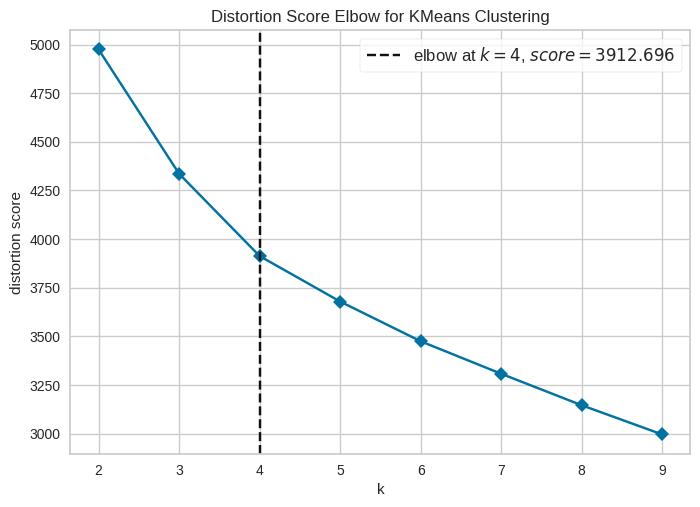

Elbow suggests k = 4


In [7]:
# ------------------------------------------------
# 5) Elbow method to select number of clusters k
# ------------------------------------------------
model = KMeans(n_init=10, random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
visualizer.fit(X)
visualizer.show();

best_k = visualizer.elbow_value_ if visualizer.elbow_value_ is not None else 3
print("Elbow suggests k =", best_k)

In [8]:
# -------------------------------
# 6) Fit K-Means with chosen k
# -------------------------------
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
kmeans.fit(X)
labels = kmeans.labels_
df['Cluster'] = labels

# Silhouette score
sil = silhouette_score(X, labels)
print(f"Silhouette score (k={best_k}): {sil:.3f}")

# Cluster sizes
from collections import Counter
print("Cluster sizes:", Counter(labels))

Silhouette score (k=4): 0.190
Cluster sizes: Counter({np.int32(1): 309, np.int32(2): 233, np.int32(0): 184, np.int32(3): 42})


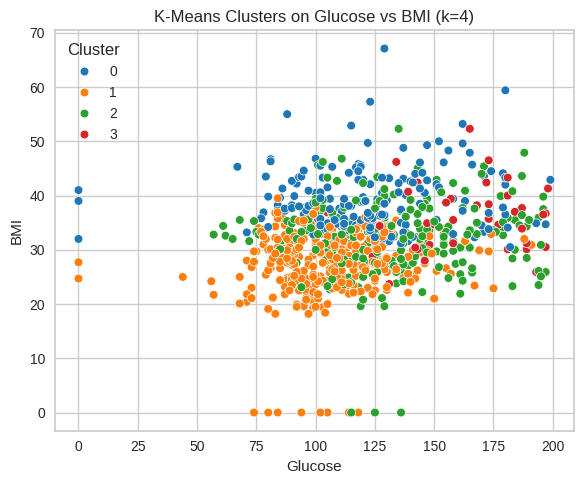

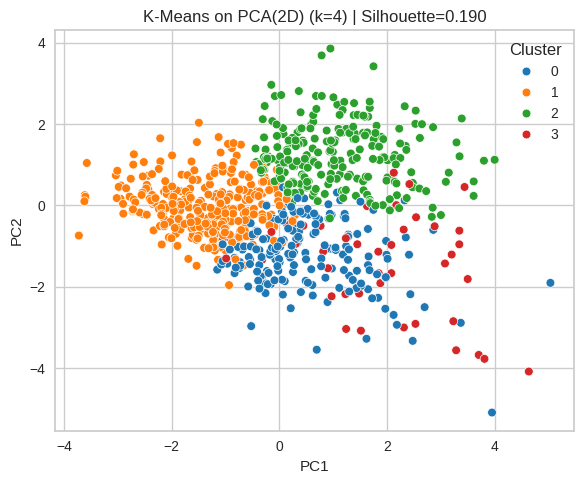

In [9]:
# --------------------------------------------
# 7) Visualizations (feature + PCA scatter)
# --------------------------------------------
# 7a) Pick two informative features to plot (available ones)
plot_x = 'Glucose' if 'Glucose' in cols else cols[0]
plot_y = 'BMI' if 'BMI' in cols else cols[min(1, len(cols)-1)]

plt.figure(figsize=(6,5))
sns.scatterplot(data=df, x=plot_x, y=plot_y, hue='Cluster', palette='tab10', s=40)
plt.title(f"K-Means Clusters on {plot_x} vs {plot_y} (k={best_k})")
plt.tight_layout()
plt.show()

# 7b) PCA to 2D for a global view
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
pcadf = pd.DataFrame(X_pca, columns=['PC1','PC2'])
pcadf['Cluster'] = labels

plt.figure(figsize=(6,5))
sns.scatterplot(data=pcadf, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=40)
plt.title(f"K-Means on PCA(2D) (k={best_k}) | Silhouette={sil:.3f}")
plt.tight_layout()
plt.show()

In [10]:
# --------------------------------
# 8) Cluster centroids (profiling)
# --------------------------------
# In original feature scale (inverse-transform)
centroids_scaled = kmeans.cluster_centers_
centroids = pd.DataFrame(scaler.inverse_transform(centroids_scaled), columns=cols)
centroids.index.name = 'Cluster'
print("\nCluster centroids (original scale):")
print(centroids.round(2))

# Per-cluster feature means from data (sanity check)
profile = df.groupby('Cluster')[cols].mean().round(2)
print("\nCluster profile (group means):")
print(profile)


Cluster centroids (original scale):
         Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
Cluster                                                                       
0               1.89   124.54          74.49          36.76   131.82  39.21   
1               2.36   106.83          66.73          23.58   112.55  27.89   
2               7.45   131.74          78.45          29.73   134.12  32.54   
3               3.36   162.12          71.10          32.83   422.69  35.97   

         DiabetesPedigreeFunction    Age  
Cluster                                   
0                            0.55  28.80  
1                            0.42  26.11  
2                            0.46  46.33  
3                            0.59  32.52  

Cluster profile (group means):
         Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
Cluster                                                                       
0               1.89   122.64          7

In [11]:
# ------------------------------------------
# 9) Predict cluster for new patient samples
# ------------------------------------------
# Example rows: [Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DPF, Age]
# Provide only columns available in your file (match 'cols' order)
new_samples = pd.DataFrame([
    #    Preg  Gluc  BP   Skin  Ins   BMI  DPF   Age
    [   2,     145,  82,  15,   88,  33.5, 0.62, 28],
    [   6,     95,   70,  30,   0,   27.4, 0.30, 50],  # Insulin=0 will be median-imputed pattern
    [   1,     170,  90,  40,   200, 38.0, 0.80, 40],
], columns=cols)

# Impute missing-style zeros like above
for c in zero_as_missing:
    if c in new_samples.columns:
        new_samples[c] = new_samples[c].replace(0, np.nan)
new_samples = new_samples.fillna(X_raw.median(numeric_only=True))

pred = kmeans.predict(scaler.transform(new_samples))
pred_df = new_samples.copy()
pred_df['Predicted_Cluster'] = pred
print("\nNew samples cluster prediction:")
print(pred_df)


New samples cluster prediction:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            2      145             82             15     88.0  33.5   
1            6       95             70             30    125.0  27.4   
2            1      170             90             40    200.0  38.0   

   DiabetesPedigreeFunction  Age  Predicted_Cluster  
0                      0.62   28                  1  
1                      0.30   50                  2  
2                      0.80   40                  0  
